In [1]:
import os
import random
import numpy as np
import cv2
from tqdm import tqdm
from glob import glob
import tifffile as tif
from sklearn.model_selection import train_test_split
from skimage.segmentation import slic, mark_boundaries
from skimage.color import label2rgb, rgb2gray
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from skimage.segmentation import mark_boundaries
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
import glob
import keras
from keras import layers
from keras.layers import Dense
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
import cv2
from cv2 import imread, createCLAHE
import glob
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from IPython.display import clear_output
from keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from skimage.morphology import binary_erosion, disk
import keras.backend as K
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel
from tqdm import tqdm
from keras.losses import Loss
from keras.callbacks import TensorBoard
from scipy.ndimage import distance_transform_edt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras.applications import VGG16, VGG19

2024-02-05 13:27:13.134609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 13:27:13.303971: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 13:27:14.272613: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/

In [2]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [8]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,
    CenterCrop,
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,
    RandomGamma,
    HueSaturationValue,
    RGBShift,
    RandomBrightness,
    RandomContrast,
    MotionBlur,
    MedianBlur,
    GaussianBlur,
    GaussNoise,
    ChannelShuffle,
    CoarseDropout
)

In [9]:
def read_data(x, y):
    """ Read the image and mask from the given path. """
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    return image, mask

In [10]:
def augment_data(images, masks, save_path, augment=True):
    """ Performing data augmentation. """
    crop_size = (128-32, 128-32)
    size = (128, 128)

    for image, mask in tqdm(zip(images, masks), total=len(images)):
        image_name = image.split("/")[-1].split(".")[0]
        mask_name = mask.split("/")[-1].split(".")[0]

        x, y = read_data(image, mask)
        try:
            h, w, c = x.shape
        except Exception as e:
            image = image[:-1]
            x, y = read_data(image, mask)
            h, w, c = x.shape

        if augment == True:
            ## Center Crop
            aug = CenterCrop(p=1, height=crop_size[0], width=crop_size[1])
            augmented = aug(image=x, mask=y)
            x1 = augmented['image']
            y1 = augmented['mask']

            ## Crop
            x_min = 0
            y_min = 0
            x_max = x_min + size[0]
            y_max = y_min + size[1]

            aug = Crop(p=1, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            ## Random Rotate 90 degree
            aug = RandomRotate90(p=1)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            ## Transpose
            aug = Transpose(p=1)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            ## ElasticTransform
            aug = ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            ## Grid Distortion
            aug = GridDistortion(p=1)
            augmented = aug(image=x, mask=y)
            x6 = augmented['image']
            y6 = augmented['mask']

            ## Optical Distortion
            aug = OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
            augmented = aug(image=x, mask=y)
            x7 = augmented['image']
            y7 = augmented['mask']

            ## Vertical Flip
            aug = VerticalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x8 = augmented['image']
            y8 = augmented['mask']

            ## Horizontal Flip
            aug = HorizontalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x9 = augmented['image']
            y9 = augmented['mask']

            ## Grayscale
            x10 = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
            y10 = y

            ## Grayscale Vertical Flip
            aug = VerticalFlip(p=1)
            augmented = aug(image=x10, mask=y10)
            x11 = augmented['image']
            y11 = augmented['mask']

            ## Grayscale Horizontal Flip
            aug = HorizontalFlip(p=1)
            augmented = aug(image=x10, mask=y10)
            x12 = augmented['image']
            y12 = augmented['mask']

            ## Grayscale Center Crop
            aug = CenterCrop(p=1, height=crop_size[0], width=crop_size[1])
            augmented = aug(image=x10, mask=y10)
            x13 = augmented['image']
            y13 = augmented['mask']

            ##
            aug = RandomBrightnessContrast(p=1)
            augmented = aug(image=x, mask=y)
            x14 = augmented['image']
            y14 = augmented['mask']

            aug = RandomGamma(p=1)
            augmented = aug(image=x, mask=y)
            x15 = augmented['image']
            y15 = augmented['mask']

            aug = HueSaturationValue(p=1)
            augmented = aug(image=x, mask=y)
            x16 = augmented['image']
            y16 = augmented['mask']

            aug = RGBShift(p=1)
            augmented = aug(image=x, mask=y)
            x17 = augmented['image']
            y17 = augmented['mask']

            aug = RandomBrightness(p=1)
            augmented = aug(image=x, mask=y)
            x18 = augmented['image']
            y18 = augmented['mask']

            aug = RandomContrast(p=1)
            augmented = aug(image=x, mask=y)
            x19 = augmented['image']
            y19 = augmented['mask']

            aug = MotionBlur(p=1, blur_limit=7)
            augmented = aug(image=x, mask=y)
            x20 = augmented['image']
            y20 = augmented['mask']

            aug = MedianBlur(p=1, blur_limit=(3, 9))
            augmented = aug(image=x, mask=y)
            x21 = augmented['image']
            y21 = augmented['mask']


            aug = GaussianBlur(p=1, blur_limit=(3, 9))
            augmented = aug(image=x, mask=y)
            x22 = augmented['image']
            y22 = augmented['mask']

            aug = GaussNoise(p=1)
            augmented = aug(image=x, mask=y)
            x23 = augmented['image']
            y23 = augmented['mask']

            aug = ChannelShuffle(p=1)
            augmented = aug(image=x, mask=y)
            x24 = augmented['image']
            y24 = augmented['mask']

            aug = CoarseDropout(p=1, max_holes=8, max_height=32, max_width=32)
            augmented = aug(image=x, mask=y)
            x25 = augmented['image']
            y25 = augmented['mask']

            images = [
                x, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10,
                x11, x12, x13, x14, x15, x16, x17, x18, x19, x20,
                x21, x22, x23, x24, x25
            ]
            masks  = [
                y, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10,
                y11, y12, y13, y14, y15, y16, y17, y18, y19, y20,
                y21, y22, y23, y24, y25
            ]

        else:
            images = [x]
            masks  = [y]

        idx = 0
        for i, m in zip(images, masks):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{image_name}_{idx}.jpg"
            tmp_mask_name  = f"{mask_name}_{idx}.jpg"

            image_path = os.path.join(save_path, "image/", tmp_image_name)
            mask_path  = os.path.join(save_path, "mask/", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1

In [11]:
def get_skin_lesion_data(path, split=0.1):
    
    train_x = glob.glob( "/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_10percent/data_agmentation/image/*.png")
    train_y = glob.glob( "/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_10percent/data_agmentation/mask/*.png")

    # valid_x = glob(os.path.join(path, "../cvc-clinic/validationx/*.png"))
    # valid_y = glob(os.path.join(path, "../cvc-clinic/validationy/*.png"))
    # 
    # test_x = glob(os.path.join(path, "cvc-clinic/testx/*.png"))
    # test_y = glob(os.path.join(path, "cvc-clinic/testy/*.png"))

    return (train_x, train_y)

In [12]:
def create_dir(path):
    """ Create a directory. """
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

In [13]:
np.random.seed(42)
path = ("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_10percent/data_agmentation")
train_x, train_y = get_skin_lesion_data(path, split=0.1)

create_dir("new_data_augmented_breast_rw_10percent/train/image/")
create_dir("new_data_augmented_breast_rw_10percent/train/mask/")
# create_dir("new_data/valid/image/")
# create_dir("new_data/valid/mask/")
# create_dir("new_data/test/image/")
# create_dir("new_data/test/mask/")

augment_data(train_x, train_y, "new_data_augmented_breast_rw_10percent/train/", augment=True)
# augment_data(valid_x, valid_y, "new_data/valid/", augment=False)
# augment_data(test_x, test_y, "new_data/test/", augment=False)


  0%|          | 0/555 [00:00<?, ?it/s]/home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
100%|██████████| 555/555 [01:22<00:00,  6.73it/s]


In [9]:
image_paths=glob.glob( "/home/somayeh/PycharmProjects/superpixel_segmentation/new_data/train/image/*.jpg")
mask_paths =glob.glob( "/home/somayeh/PycharmProjects/superpixel_segmentation/new_data/train/mask/*.jpg")

In [11]:
target_size = (128, 128)
# Create output directories if they don't exist
os.makedirs("/home/somayeh/PycharmProjects/superpixel_segmentation/new_data/train/resized_image", exist_ok=True)
os.makedirs("/home/somayeh/PycharmProjects/superpixel_segmentation/new_data/train/resized_mask", exist_ok=True)

# Function to resize and save an image
def resize_and_save(image_path, output_path):
    image = cv2.imread(image_path)
    if image is not None:
        resized_image = cv2.resize(image, target_size)
        cv2.imwrite(output_path, resized_image)

# Process and resize the images
for image_path in image_paths:
    # Generate the output path for the resized image
    output_path = image_path.replace("image", "resized_image")
    resize_and_save(image_path, output_path)

# Repeat the same process for mask images
for mask_path in mask_paths:
    # Generate the output path for the resized mask
    output_path = mask_path.replace("mask", "resized_mask")
    resize_and_save(mask_path, output_path)

In [10]:
# initialize empty arrays to hold the images and masks
images = []
masks = []
images_superpixel = []
binary_masks = []
masks_superpixel = []
masks_result = []
binary = []

In [11]:
def ground_truth_superpixel_1(img, ground_truth):
    # Perform superpixel segmentation
    num_segments = 800
    segments = slic(img, n_segments=num_segments, compactness=10)
    # segments = felzenszwalb(img, scale=20, sigma=0.5, min_size=30)
    # segments = quickshift(img, kernel_size=1, max_dist=2.5, ratio=0.5)

    # gradient = sobel(rgb2gray(img))
    # segments = watershed(gradient, markers=800, compactness=0.001)

    image_superpixel = label2rgb(segments, img, kind='avg')
    image_superpixel = rgb2gray(image_superpixel)
    num_superpixels = len(np.unique(segments))
    # print(f'The image contains {num_superpixels} superpixels.')

    image_boundaries = mark_boundaries(img, segments, color=(255, 0, 0))
    labels = segments.astype(np.int32)

    # Overlay superpixels with ground truth
    inside_mask = (ground_truth == 255)  # white pixels in ground truth are inside the chest region
    outside_mask = (ground_truth == 0)  # black pixels in ground truth are outside the chest region
    boundary_mask = cv2.morphologyEx(ground_truth, cv2.MORPH_GRADIENT, np.ones((5, 5), np.uint8)) > 0

    inside_superpixels = set(np.unique(labels[inside_mask]))
    outside_superpixels = set(np.unique(labels[outside_mask]))
    boundary_superpixels = set(np.unique(labels[boundary_mask]))

    # Exclude boundary superpixels
    valid_superpixels = list(outside_superpixels.union(inside_superpixels) - boundary_superpixels)

    for label in boundary_superpixels:
        mask = (labels == label)
        # Check if the superpixel intersects with the boundary
        if np.any(mask[0, :]) or np.any(mask[-1, :]) or np.any(mask[:, 0]) or np.any(mask[:, -1]):
            boundary_mask_ = binary_erosion(boundary_mask,
                                            disk(
                                                3))  # erode the boundary mask to avoid including partial boundary pixels
            valid_superpixels = list(outside_superpixels.union(inside_superpixels) - set(labels[boundary_mask_]))

    num_segments_result = len(np.unique(valid_superpixels))
    # print(f'The result image contains {num_segments_result} superpixels.')

    # Assign labels and color superpixels
    result = np.zeros_like(img)
    inside_labels = []
    outside_labels = []
    for label in valid_superpixels:
        mask = (labels == label)
        if label in inside_superpixels:
            color = (255, 255, 255)  # yellow for inside superpixels
            inside_labels.append(label)
        else:
            color = (0, 0, 0)  # blue for outside superpixels
            outside_labels.append(label)
        result[mask] = color

    # Set background class for the omitted superpixels
    background_mask = (ground_truth == 0)
    result[background_mask] = (0, 0, 0)

    # # Show number of labels in the result image
    # print(
    #     f"The result image contains {len(inside_labels)} inside superpixels and {len(outside_labels)} outside superpixels.")

    # Visualize the result
    # cv2.imshow('Image', img)
    # cv2.imshow('Ground Truth', ground_truth)
    # cv2.imshow('Superpixels',
    #            cv2.cvtColor(cv2.normalize(labels, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U), cv2.COLOR_GRAY2BGR))
    # cv2.imshow('Result', result)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    #
    # fig, ax = plt.subplots(1, 4, figsize=(10, 5))
    # ax[0].imshow(image_superpixel)
    # ax[0].set_title('Superpixel image')
    # ax[1].imshow(ground_truth, cmap='gray')
    # ax[1].set_title('Binary ground truth')
    # ax[2].imshow(image_boundaries)
    # ax[2].set_title('Mark boundaries')
    # ax[3].imshow(result)
    # ax[3].set_title('Ground truth result')
    # plt.show()
    return result

In [12]:
def ground_truth_superpixel_3(img, ground_truth):
    # Perform SLIC superpixel segmentation
    num_segments = 800
    segments = slic(img, n_segments=num_segments, compactness=10)
    # segments = felzenszwalb(img, scale=20, sigma=0.5, min_size=30)
    # segments = quickshift(img, kernel_size=1, max_dist=2.5, ratio=0.5)

    # Find superpixels intersecting with the image boundaries
    boundary_mask = cv2.morphologyEx(ground_truth, cv2.MORPH_GRADIENT, np.ones((5, 5), np.uint8)) > 0
    boundary_superpixels = set(segments[boundary_mask])

    # Show the number of superpixels with intersection with image boundaries
    num_boundary_superpixels = len(boundary_superpixels)
    # print(f'The number of superpixels with intersection with image boundaries: {num_boundary_superpixels}')

    # Overlay superpixels with ground truth
    labels = segments.astype(np.int32)

    inside_mask = (ground_truth == 255)  # white pixels in ground truth are inside the chest region
    outside_mask = (ground_truth == 0)  # black pixels in ground truth are outside the chest region

    inside_superpixels = set(np.unique(labels[inside_mask]))
    outside_superpixels = set(np.unique(labels[outside_mask]))

    # Assign labels and color superpixels
    result = np.zeros_like(img)
    for label in outside_superpixels:
        mask = (labels == label)
        result[mask] = (0, 0, 0)  # Set label 0 (black) for superpixels outside the boundary

    for label in inside_superpixels:
        mask = (labels == label)
        result[mask] = (255, 255, 255)  # Set label 1 (white) for superpixels inside the boundary

    for label in boundary_superpixels:
        mask = (labels == label)
        num_pixels_inside = np.sum(mask & inside_mask)
        num_pixels_outside = np.sum(mask & outside_mask)

        if num_pixels_outside > num_pixels_inside:
            result[mask] = (0, 0, 0)  # Set label 0 (black) for superpixels with more pixels outside the boundary
        elif num_pixels_outside < num_pixels_inside:
            result[mask] = (255, 255, 255)  # Set label 1 (white) for superpixels with more pixels inside the boundary
        else:
            d1 = cv2.distanceTransform((mask & outside_mask).astype(np.uint8), cv2.DIST_L2, 5)
            d2 = cv2.distanceTransform((mask & inside_mask).astype(np.uint8), cv2.DIST_L2, 5)

            d1_sorted = np.sort(d1[mask & boundary_mask])
            d2_sorted = np.sort(d2[mask & boundary_mask])

            threshold_idx = len(d1_sorted) // 2
            if np.sum(d1_sorted[:threshold_idx]) > np.sum(d1_sorted[threshold_idx:]):
                result[mask] = (0, 0, 0)  # Set label 0 (black) for superpixels with larger distance to outside
            else:
                result[mask] = (255, 255, 255)  # Set label 1 (white) for superpixels with larger distance to inside

    # cv2.imshow('Result', result)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return result

In [13]:
def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

In [14]:
def precision(y_true, y_pred):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true_flat * y_pred_flat, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_flat, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    return precision

In [15]:
def sensitivity(gt_mask, pred_mask):
    """
    Computes sensitivity (recall) of the predicted segmentation mask
    given the ground truth mask.

    Args:
        gt_mask (np.array): binary ground truth segmentation mask.
        pred_mask (np.array): binary predicted segmentation mask.

    Returns:
        float: sensitivity score.
    """
    gt_mask_flat = K.flatten(gt_mask)
    pred_mask_flat = K.flatten(pred_mask)

    # compute true positive (TP) and false negative (FN) counts
    TP = K.sum(gt_mask_flat * pred_mask_flat)
    FN = K.sum(gt_mask_flat * (1 - pred_mask_flat))

    # compute sensitivity (recall)
    if TP + FN == 0:
        sensitivity_score = 0.0
    else:
        sensitivity_score = TP / (TP + FN)

    return sensitivity_score

In [16]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [17]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred,1)

In [18]:
image_path_1 = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/new_data/train/resized_image/*.jpg")
mask_path_1 = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/new_data/train/resized_mask/*.jpg")

In [19]:
batch_size = 8
threshold_value = 128
def data_generator(image_paths, mask_paths, batch_size):

    assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same."

    num_samples = len(image_paths)
    print("Number of images:", num_samples)
    num_masks = len(mask_paths)
    print("Number of masks:", num_masks)

    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i : i + batch_size]
            batch_images = []
            batch_masks = []

            for index in batch_indices:
                image_path = image_paths[index]
                mask_path = mask_paths[index]

                img = cv2.imread(image_path)
                # img = cv2.resize(img, (256, 256))

                filename = os.path.join("/home/somayeh/PycharmProjects/superpixel_segmentation/"
                                        "newgt/newgt_superpixel_128_CVC_slic800", os.path.basename(mask_path))
                if not os.path.exists(filename):

                    mask = cv2.imread(mask_path,0)
                    # mask = cv2.resize(mask, (256, 256))

                    result = ground_truth_superpixel_1(img, mask)
                    # result = ground_truth_superpixel_3(img, mask)

                    # result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
                    # plt.subplot(1, 2, 2)
                    # plt.imshow(result)
                    # plt.title("hggh")

                    # soft_label = binary_to_soft_label(result, threshold_value=threshold_value)
                    # cv2.imshow("kjkj",soft_label)
                    # cv2.waitKey(0)
                    # result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

                    cv2.imwrite(filename, result)

                else:
                    result = cv2.imread(filename, 0)
                # print(result.type)
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # soft_label = binary_to_soft_label(result)

                # normalize the image and mask to have values between 0 and 1
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img / 255.0
                result= result/ 255.0
                # result = result / 255.0
                # print(soft_label.shape)
                # cv2.imshow("dfg", soft_label)
                # cv2.waitKey(0)
                # Append the preprocessed data to the respective lists

                batch_images.append(img)
                batch_masks.append(result)

            # Yield the batch data
            batch_images = np.array(batch_images)
            batch_masks = np.array(batch_masks)

            # Visualize the images and masks in the batch
            # for j in range(batch_images.shape[0]):
            #     plt.subplot(1, 2, 1)
            #     plt.imshow(batch_images[j])
            #     plt.title("Image")
            #
            #     plt.subplot(1, 2, 2)
            #     plt.imshow(batch_masks[j])
            #     plt.title("Mask")
            #
            #     plt.show()

            yield batch_images, batch_masks
#
# generator = data_generator(image_path_1, mask_path_1, 1)
# 
# for _,imgpath in tqdm(enumerate(image_paths)):
#    batch = next(generator)

In [20]:
mask_path_superpixel = glob.glob ("/home/somayeh/PycharmProjects/superpixel_segmentation/newgt/newgt_superpixel_128_CVC_slic800/*.jpg")
assert len(image_path_1) == len(mask_path_superpixel), "Number of images and masks must be the same."
# Split the data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_path_1, mask_path_superpixel, test_size=0.2, random_state=2023
)

# Define the batch size
batch_size = 8

# Create separate generators for training and validation sets
train_generator = data_generator(train_image_paths, train_mask_paths, batch_size)
val_generator = data_generator(val_image_paths, val_mask_paths, batch_size)

# batch_size = 5  # Number of batches to visualize

# for _ in range(batch_size):
#     batch = next(train_generator)

# Determine the number of steps per epoch for training and validation
train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

print(train_steps_per_epoch)
print(val_steps_per_epoch)

1417
354


In [21]:
def build_unet(input_size=(256,256,3)):

    inputs  = Input(input_size)

    conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool5)
    conv6 = Conv2D(1024, (3, 3), activation = 'relu', padding='same')(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)


    up7 = layers.concatenate([Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(conv6), conv5], axis=3)


    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv7)


    up8 = layers.concatenate([Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(conv7), conv4], axis=3)

    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.concatenate([Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv8), conv3], axis=3)

    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv9)

    up10 = layers.concatenate([Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv9), conv2], axis=3)

    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(up10)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)

    up11 = layers.concatenate([Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv10), conv1], axis=3)

    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(up11)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv11)

    conv12 = Conv2D(1, (1,1), activation='relu')(conv11)

    return Model(inputs=[inputs], outputs=[conv12])

In [22]:
def build_unet_pretrained (input_size=(256, 256, 3)):
    # Load pre-trained VGG16 model without top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=input_size))

    # Encoder part (using VGG16 layers)
    encoder = base_model.get_layer('block5_conv3').output

    # Decoder part (U-Net)
    up7 = UpSampling2D(size=(2, 2))(encoder)
    up7 = Conv2D(512, (2, 2), activation='relu', padding='same')(up7)
    up7 = concatenate([up7, base_model.get_layer('block4_conv3').output], axis=-1)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv7)

    up6 = UpSampling2D(size=(2, 2))(conv7)
    up6 = Conv2D(256, (2, 2), activation='relu', padding='same')(up6)
    up6 = concatenate([up6, base_model.get_layer('block3_conv3').output], axis=-1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up5 = UpSampling2D(size=(2, 2))(conv6)
    up5 = Conv2D(128, (2, 2), activation='relu', padding='same')(up5)
    up5 = concatenate([up5, base_model.get_layer('block2_conv2').output], axis=-1)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up4 = UpSampling2D(size=(2, 2))(conv5)
    up4 = Conv2D(64, (2, 2), activation='relu', padding='same')(up4)
    up4 = concatenate([up4, base_model.get_layer('block1_conv2').output], axis=-1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

    up3 = UpSampling2D(size=(2, 2))(conv4)
    up3 = Conv2D(32, (2, 2), activation='relu', padding='same')(up3)

    # Continue with the rest of your U-Net decoder as before

    # Final convolutional layer
    conv12 = Conv2D(1, (1, 1), activation='sigmoid')(up3)

    return Model(inputs=[base_model.input], outputs=[conv12])

In [23]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

# def encoder2(inputs):
#     skip_connections = []
#
#     output = DenseNet121(include_top=False, weights='imagenet')(inputs)
#     model = tf.keras.models.Model(inputs, output)
#
#     names = ["input_2", "conv1/relu", "pool2_conv", "pool3_conv"]
#     for name in names:
#         skip_connections.append(model.get_layer(name).output)
#     output = model.get_layer("pool4_conv").output
#
#     return output, skip_connections

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    # outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs2)
    return model

In [24]:
!rm -rf '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'

In [25]:
%load_ext tensorboard
log_folder = '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'

In [37]:
weight_path="{}_Unet_superpixel_cvc_slic800.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-5)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=10) # probably needs to be more patient, but kaggle time is limited

tbcallback = TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)

callbacks_list = [checkpoint, early, reduceLROnPlat, tbcallback]

2023-10-17 14:48:53.113701: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-10-17 14:48:53.113737: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-10-17 14:48:53.140500: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-10-17 14:48:53.140769: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [29]:
model =build_model((128,128,3))
opt = tf.keras.optimizers.experimental.AdamW(learning_rate=0.0001)
model.compile(optimizer=opt, loss= dice_coef_loss,metrics= [dice_coef, precision, iou, sensitivity] ,run_eagerly=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [ ]:

loss_history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    epochs=50,
    callbacks =callbacks_list
)

model.save("unet_super_pixel_extended_cvc_slic800.h5")

In [67]:
# model = load_model('unet_super_pixel_extended_cvc_slic800.h5')
model.load_weights("{}_Unet_superpixel_cvc_slic800.best.hdf5".format('cxr_reg'))


In [68]:
test_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/new_data/valid/image/*.jpg")
test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/new_data/valid/mask/*.jpg")

# test_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/PolypDataset/TestDataset/TestDataset/ETIS-LaribPolypDB/images/*.png")
# test_mask_paths= glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/PolypDataset/TestDataset/TestDataset/ETIS-LaribPolypDB/masks/*.png")

(13, 128, 128, 3)
(13, 128, 128)
13/13 [==============================] - 3s 263ms/step
(13, 128, 128, 1)
(13, 128, 128, 1)
(13, 128, 128)
Dices: [<tf.Tensor: shape=(), dtype=float64, numpy=0.7509692412042486>, <tf.Tensor: shape=(), dtype=float64, numpy=0.7717809947292708>, <tf.Tensor: shape=(), dtype=float64, numpy=0.7692572319464669>, <tf.Tensor: shape=(), dtype=float64, numpy=0.5418989564265796>, <tf.Tensor: shape=(), dtype=float64, numpy=0.8135856765690007>, <tf.Tensor: shape=(), dtype=float64, numpy=0.5639337863492008>, <tf.Tensor: shape=(), dtype=float64, numpy=0.7705921025569229>, <tf.Tensor: shape=(), dtype=float64, numpy=0.8352672040350445>, <tf.Tensor: shape=(), dtype=float64, numpy=0.7105178088722007>, <tf.Tensor: shape=(), dtype=float64, numpy=0.7704331188329856>, <tf.Tensor: shape=(), dtype=float64, numpy=0.571202710037048>, <tf.Tensor: shape=(), dtype=float64, numpy=0.7930264890753927>, <tf.Tensor: shape=(), dtype=float64, numpy=0.41455262690580685>]
Dice coefficient: 0.6

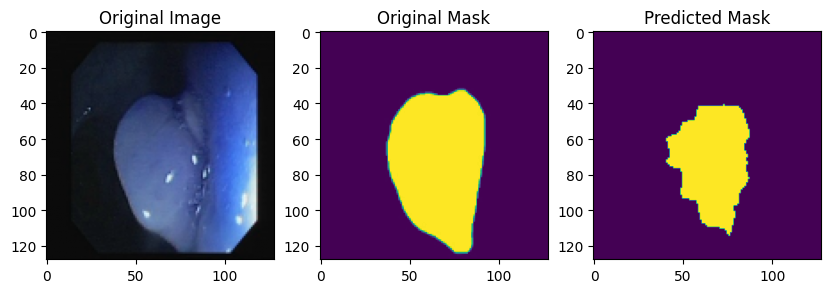

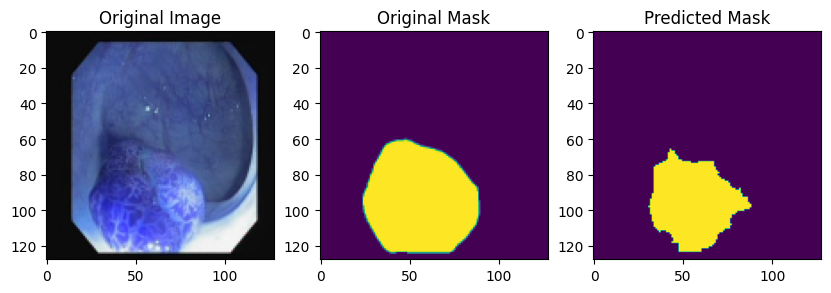

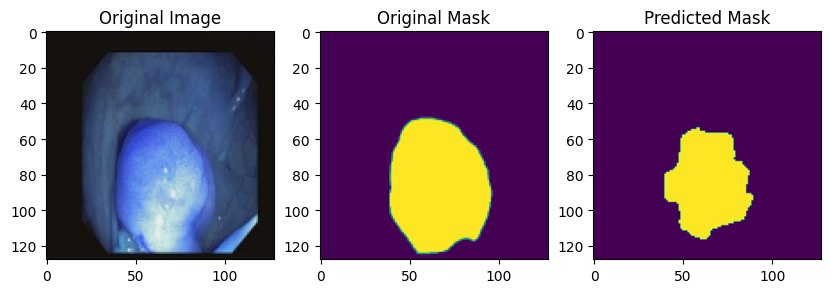

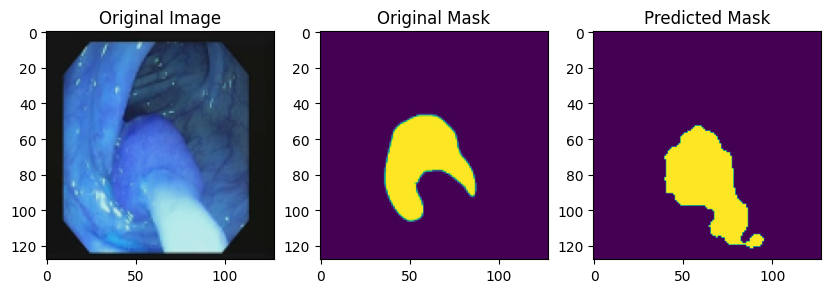

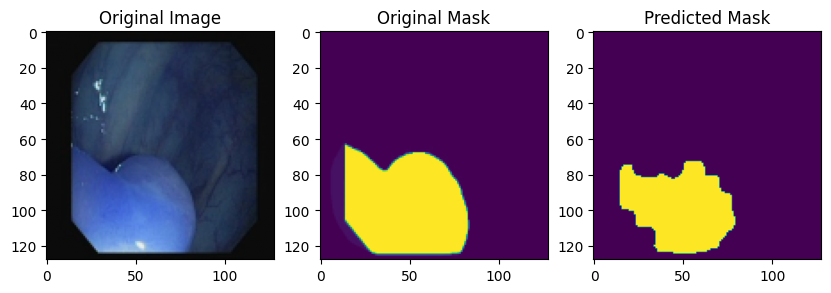

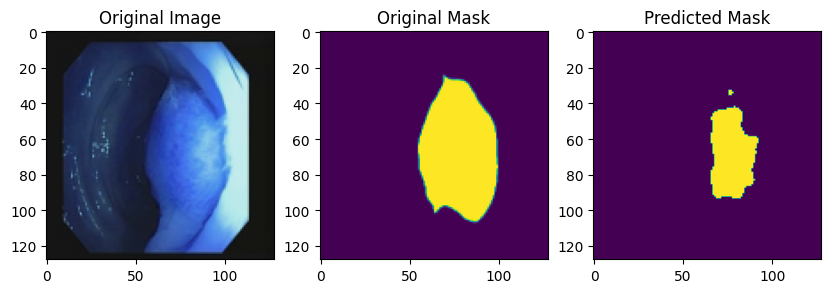

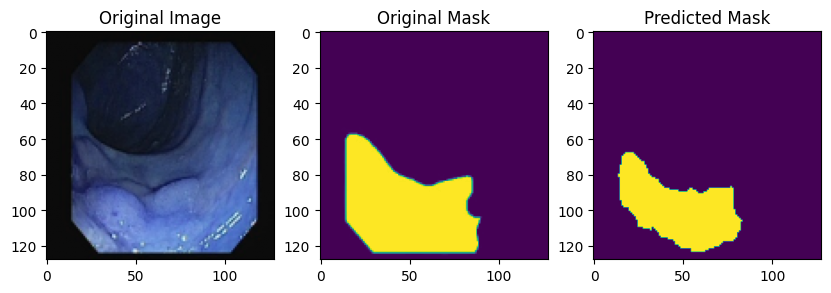

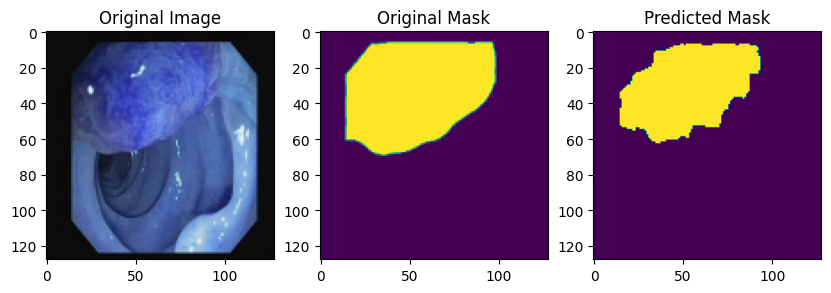

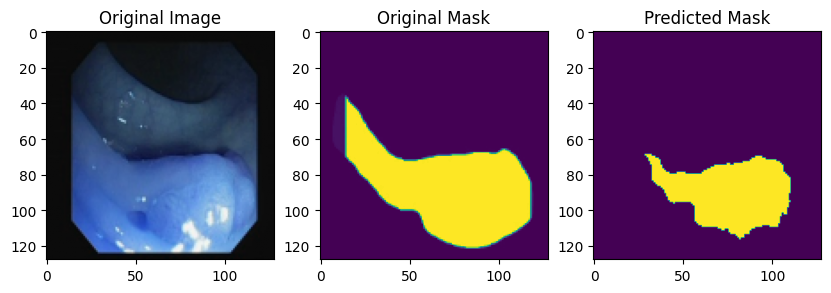

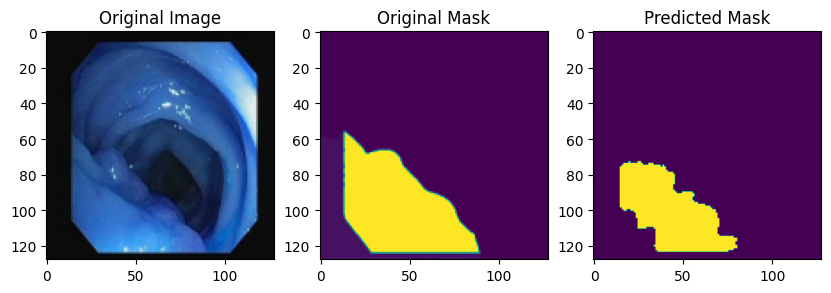

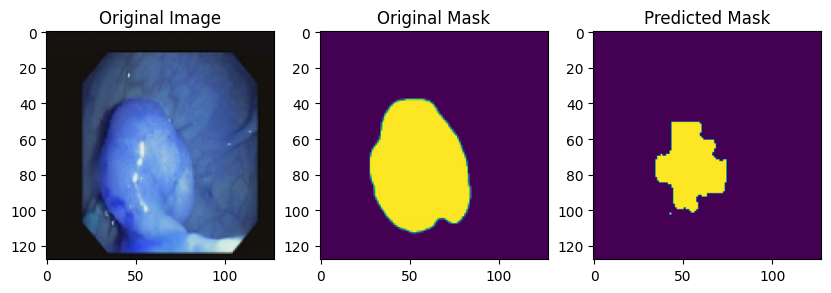

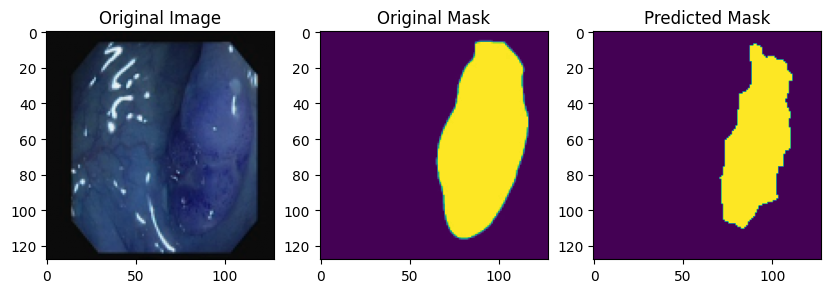

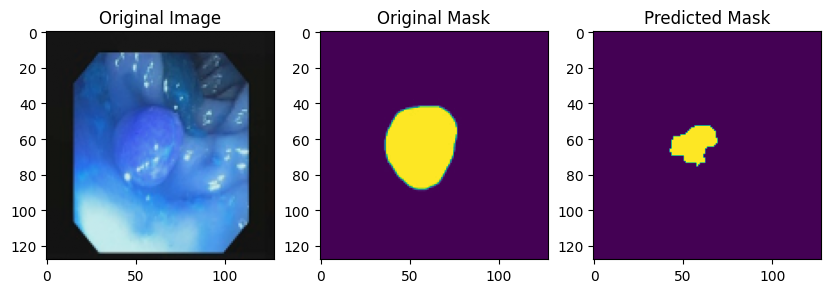

IndexError: index 13 is out of bounds for axis 0 with size 13

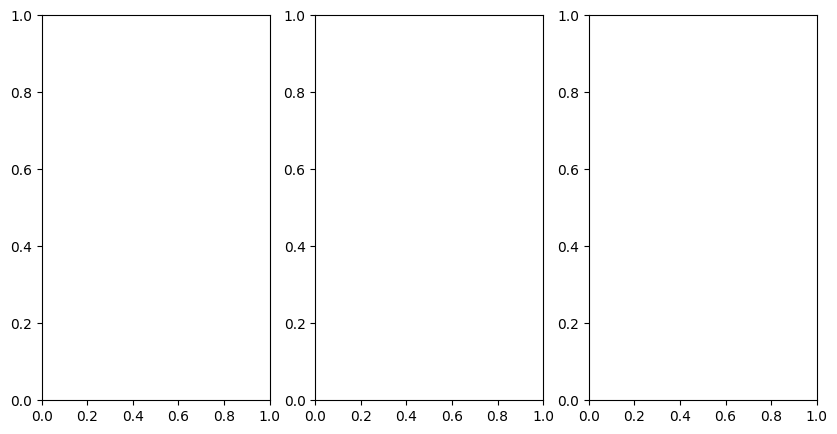

In [69]:
dice_scores = []
test_images = []
ground_truth_test_images = []
for test_path, test_mask_path in zip(test_paths, test_mask_paths):
    # read the image and mask using OpenCV
    test_image = cv2.imread(test_path)
    ground_truth_test_image = cv2.imread(test_mask_path, 0)  # read the mask as grayscale

    # resize the image and mask to the desired dimensions
    test_image = cv2.resize(test_image, (128, 128))
    ground_truth_test_image = cv2.resize(ground_truth_test_image, (128, 128))

# normalize the image and mask to have values between 0 and 1

    test_image = test_image / 255.0
    ground_truth_test_image= ground_truth_test_image / 255.0

    # add the image and mask to the corresponding arrays
    test_images.append(test_image)
    ground_truth_test_images.append(ground_truth_test_image)


#by the end of this line, I have superpixeled images.
# convert the images and masks to numpy arrays
test_images = np.array(test_images)
ground_truth_test_images = np.array(ground_truth_test_images)
print(test_images.shape)
print(ground_truth_test_images.shape)
# add a channel dimension to the masks
# ground_truth_test_images = np.expand_dims(ground_truth_test_images, axis=-1)

# model = load_model('unet_super_pixel_extended_cvc_slic800.h5')
# model.load_weights("{}_Unet_superpixel_cvc_slic800.best.hdf5".format('cxr_reg'))


# Make predictions
# predicted_masks = model.predict(test_images)
tf.config.run_functions_eagerly(True)
predicted_masks = model.predict(
    test_images,
    batch_size=1,
    verbose=1,
    steps=None,
    callbacks=None
)

predicted_mask_array = np.array(predicted_masks)
print(predicted_mask_array.shape)

# Convert the NumPy array to uint8 format
predicted_mask_array = (predicted_mask_array * 255).astype(np.uint8)
print(predicted_mask_array.shape)


dst = np.empty([predicted_mask_array.shape[0],predicted_mask_array.shape[1],predicted_mask_array.shape[2]])
kernel = np.ones((5,5),np.float64)/25
# dst = predicted_mask_array

#
for i in range(predicted_mask_array.shape[0]):

        threshold_value = 1
        _, dst[i] = cv2.threshold(predicted_mask_array[i], threshold_value, 255, cv2.THRESH_BINARY)
        dst[i] = np.array(dst[i])
        dst[i] = tf.convert_to_tensor(dst[i] / 255.0,dtype=predicted_masks.dtype)

print(dst.shape)

## Cast the input tensor to a double tensor
ground_truth_test_images = tf.cast(ground_truth_test_images, dtype=tf.float64)
predicted_masks = tf.cast(dst, dtype=tf.float64)
# predicted_masks = tf.cast(predicted_mask_array, dtype=tf.float64)
# Apply thresholding

dice_scores = []  # List to store the dice coefficients
precision_scores = []
sensitivity_scores = []
iou_scores = []

# Iterate over the images and calculate the dice coefficient
for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    dice = dice_coef(y_true, y_pred)
    dice_scores.append(dice)

# Compute the average dice coefficient
average_dice = np.mean(dice_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    dice = dice_coef(y_true, y_pred)

    y_pred = predicted_masks[i]

    precision_value = precision(y_true, y_pred)
    precision_scores.append(precision_value)

# Compute the average dice coefficient
average_precision = np.mean(precision_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    sensitivity_value = sensitivity(y_true, y_pred)
    sensitivity_scores.append(sensitivity_value)

# Compute the average dice coefficient
average_sensitivity = np.mean(sensitivity_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    iou_value = iou(y_true, y_pred)
    iou_scores.append(iou_value)

# Compute the average dice coefficient
average_iou = np.mean(iou_scores)

# dice_score = dice_coef(ground_truth_test_images, dst)
# precision_val = precision(ground_truth_test_images, dst)
# sensitivity_val = sensitivity(ground_truth_test_images, dst)
# iou_val = iou(ground_truth_test_images, dst)
# print(type(dst))

print("Dices:", dice_scores)
print("Dice coefficient:", average_dice)
print("Precision:", average_precision)
print("Sensitivity:", average_sensitivity)
print("IoU:", average_iou)

n =35 # number of images to show
for i in range(n):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(test_images[i])
    ax[0].set_title('Original Image')
    ax[1].imshow(ground_truth_test_images[i])
    ax[1].set_title('Original Mask')
    ax[2].imshow(dst[i])
    ax[2].set_title('Predicted Mask')
    plt.show()